In [213]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate, Activation
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.utils import to_categorical

In [3]:
def down_cast(df: pd.DataFrame):  #data frame optimization
    int8_min, int8_max = -128, 127
    int16_min, int16_max = -32768, 32767
    int32_min, int32_max = -2147483648, 2147483647

    cols = df.columns
    for col in cols:
        if df[col].dtype == 'int64':
            min_val = df[col].min()
            max_val = df[col].max()
            
            if (min_val == 0) and (max_val == 0):
                df = df.drop(columns=col)
                continue

            if min_val >= int8_min and max_val <= int8_max:
                df[col] = df[col].astype('int8')
            elif min_val >= int16_min and max_val <= int16_max:
                df[col] = df[col].astype('int16')
            elif min_val >= int32_min and max_val <= int32_max:
                df[col] = df[col].astype('int32')
            else:
                pass

        elif (df[col].dtype == 'O') and (df[col].nunique() < 5):
            df[col] = df[col].astype('category')
                
    return df

#reduced from 25MB to 10MB

# Data Frame Optimization

In [4]:
df = pd.read_csv('MalwareMemoryDump.csv', usecols=lambda column: column != 'Raw_Type')

In [5]:
df = down_cast(df)

In [6]:
info = pd.concat([df.describe(include=np.number), pd.DataFrame(df.dtypes).T. \
                  rename(index={0: 'dtype'}).drop(columns=['SubType', 'Label'])])

# Categorical Encoding

In [9]:
df['Label'] = df['Label'].map({'Benign': 0, 'Malware': 1})
df['SubType'] = df['SubType'].map({'Benign': 0, 'Ransomware': 1, 'Spyware': 2, 'Trojan': 3})

In [10]:
Label_dict = {0: 'Benign', 1: 'Malware'}
subtype_dict = {'Benign': 0, 'Ransomware': 1, 'Spyware': 2, 'Trojan': 3}

# Create a Test Set

In [13]:
x_train, x_test = train_test_split(df, test_size=.17, stratify=df[['SubType', 'Label']],
                                    random_state=42)

In [14]:
x_train_feats = x_train.drop(columns=['SubType', 'Label'])
x_test_feats = x_test.drop(columns=['SubType', 'Label'])
y_train = x_train[['SubType', 'Label']]
y_test = x_test[['SubType', 'Label']]

# Training Models

In [122]:
y_train_multiclass = to_categorical(y_train['SubType'], num_classes=4)
y_test_multiclass = to_categorical(y_test['SubType'], num_classes=4)

In [162]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=30, 
                                                     #monitor=['val_Output_layer_binary_loss', 'val_Output_layer_multi_loss'],
                                                     restore_best_weights=True,
                                                     start_from_epoch=20,
                                                     verbose=1)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('checkpoints', save_best_only=True,
                                                   save_weights_only=True, verbose=1)

In [163]:
input = Input(shape=(52,))

hidden1 = Dense(512, kernel_initializer='he_normal')(input)
BN_1 = BatchNormalization()(hidden1)
act1 = Activation('relu')(BN_1)

hidden2 = Dense(256, kernel_initializer='he_normal')(act1)
BN_2 = BatchNormalization()(hidden2)
act2 = Activation('relu')(BN_2)

hidden3 = Dense(128, kernel_initializer='he_normal')(act2)
BN_3 = BatchNormalization()(hidden3)
act3 = Activation('relu')(BN_3)

hidden4 = Dense(64, kernel_initializer='he_normal')(act3)
BN_4 = BatchNormalization()(hidden4)
act4 = Activation('relu')(BN_4)

hidden5 = Dense(32, kernel_initializer='he_normal')(act4)
BN_5 = BatchNormalization()(hidden5)
act5 = Activation('relu')(BN_5)

hidden6 = Dense(16, kernel_initializer='he_normal')(act5)
BN_6 = BatchNormalization()(hidden6)
act6 = Activation('relu')(BN_6)

output1 = Dense(4, activation='linear', name='Output_layer_multi')(act6)
output2 = Dense(1, activation='sigmoid', name='Output_layer_binary')(act6)

model = tf.keras.Model(inputs=[input], outputs=[output1, output2])

In [165]:
opt = tf.keras.optimizers.Adam()
loss1 = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
loss2 = tf.keras.losses.BinaryCrossentropy()
metrics = {
    'Output_layer_multi': [Recall(name='recall_multiclass'), Precision(name='precision_multiclass'), AUC(name='row_auc')],
    'Output_layer_binary': [Recall(name='recall_binary'), Precision(name='precision_binary')]
}
target_data = {
    'Output_layer_multi': y_train_multiclass,
    'Output_layer_binary': y_train['Label']
}
model.compile(
    loss={'Output_layer_multi': loss1, 'Output_layer_binary': loss2},
    optimizer=opt,
    metrics=metrics
)

In [166]:
history = model.fit(x_train_feats, target_data, 
          epochs=1000, validation_split=.2, 
          callbacks=[early_stopping_cb, checkpoint_cb])

Epoch 1/1000
1210/1216 [============================>.] - ETA: 0s - loss: 0.6766 - Output_layer_multi_loss: 0.6029 - Output_layer_binary_loss: 0.0737 - Output_layer_multi_recall_multiclass: 0.9154 - Output_layer_multi_precision_multiclass: 0.5304 - Output_layer_multi_row_auc: 0.8898 - Output_layer_binary_recall_binary: 0.9858 - Output_layer_binary_precision_binary: 0.9894
Epoch 1: val_loss improved from inf to 0.57073, saving model to checkpoints
1216/1216 [==============================] - 59s 9ms/step - loss: 0.6762 - Output_layer_multi_loss: 0.6028 - Output_layer_binary_loss: 0.0735 - Output_layer_multi_recall_multiclass: 0.9156 - Output_layer_multi_precision_multiclass: 0.5303 - Output_layer_multi_row_auc: 0.8897 - Output_layer_binary_recall_binary: 0.9858 - Output_layer_binary_precision_binary: 0.9894 - val_loss: 0.5707 - val_Output_layer_multi_loss: 0.5468 - val_Output_layer_binary_loss: 0.0239 - val_Output_layer_multi_recall_multiclass: 0.9681 - val_Output_layer_multi_precision_

In [172]:
loss = pd.DataFrame(history.history)[['Output_layer_multi_loss', 
                                      'Output_layer_binary_loss', 
                                      'val_Output_layer_multi_loss', 
                                      'val_Output_layer_binary_loss']]

recall = pd.DataFrame(history.history)[['Output_layer_multi_recall_multiclass', 
                                        'Output_layer_binary_recall_binary',
                                        'val_Output_layer_multi_recall_multiclass',
                                        'val_Output_layer_binary_recall_binary']]

precision = pd.DataFrame(history.history)[['Output_layer_multi_precision_multiclass',
                                           'Output_layer_binary_precision_binary',
                                           'val_Output_layer_multi_precision_multiclass',
                                           'val_Output_layer_binary_precision_binary']]

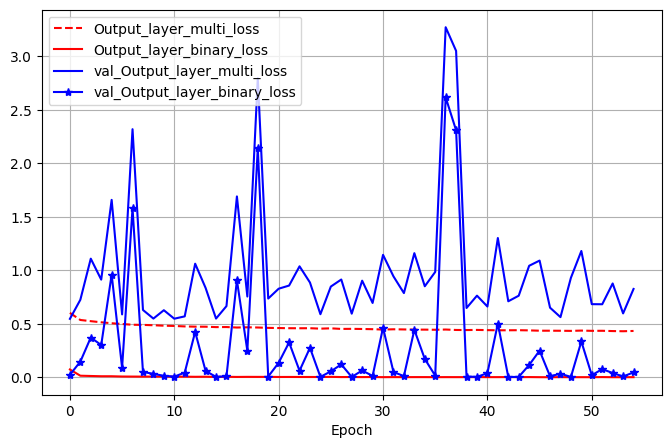

In [171]:
pd.DataFrame(loss).plot(figsize=(8, 5), grid=True, 
                        style=['r--', 'r', 'b-', 'b-*'], xlabel='Epoch')
plt.show()

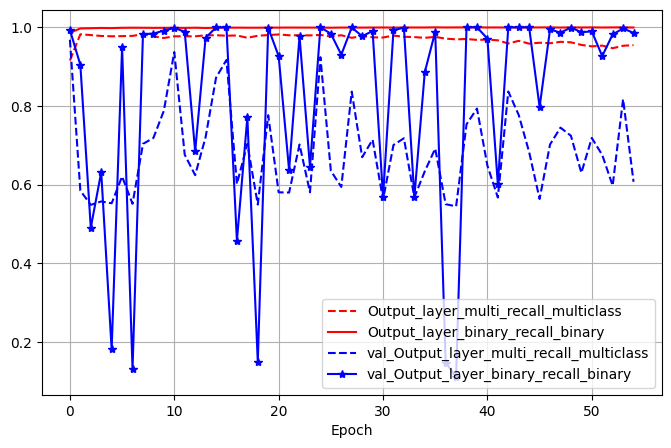

In [176]:
pd.DataFrame(recall).plot(figsize=(8, 5), grid=True, 
                        style=['r--', 'r', 'b--', 'b-*'], xlabel='Epoch')
plt.show()

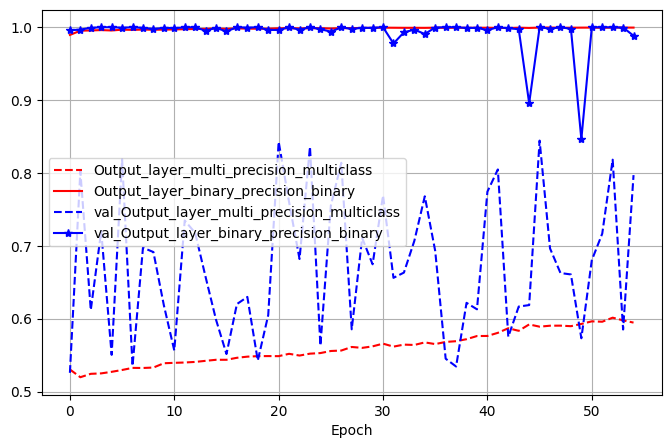

In [177]:
pd.DataFrame(precision).plot(figsize=(8, 5), grid=True, 
                        style=['r--', 'r', 'b--', 'b-*'], xlabel='Epoch')
plt.show()

In [260]:
preds = model.predict(x_test_feats)

312/312 [==============================] - 1s 3ms/step


In [261]:
subtype_preds = np.argmax(preds[0], axis=1)
label_preds = np.where(preds[1] > .5, 1, 0)

In [263]:
subtype_cr = classification_report(y_test.iloc[:, 0], subtype_preds)
label_cr = classification_report(y_test.iloc[:, 1], label_preds)

In [264]:
print(subtype_cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4981
           1       0.71      0.13      0.22      1665
           2       0.36      0.97      0.52      1703
           3       0.86      0.03      0.05      1613

    accuracy                           0.69      9962
   macro avg       0.73      0.53      0.45      9962
weighted avg       0.82      0.69      0.63      9962



In [268]:
model.evaluate(x_test_feats, (y_test_multiclass, y_test['Label']))[0]

312/312 [==============================] - 1s 3ms/step - loss: 0.6017 - Output_layer_multi_loss: 0.5985 - Output_layer_binary_loss: 0.0032 - Output_layer_multi_recall_multiclass: 0.9191 - Output_layer_multi_precision_multiclass: 0.5597 - Output_layer_multi_row_auc: 0.8809 - Output_layer_binary_recall_binary: 0.9991 - Output_layer_binary_precision_binary: 0.9987


0.6017114520072937

In [280]:
model.evaluate(x_test_feats, (y_test_multiclass, y_test['Label']))

312/312 [==============================] - 1s 3ms/step - loss: 0.6017 - Output_layer_multi_loss: 0.5985 - Output_layer_binary_loss: 0.0032 - Output_layer_multi_recall_multiclass: 0.9191 - Output_layer_multi_precision_multiclass: 0.5597 - Output_layer_multi_row_auc: 0.8809 - Output_layer_binary_recall_binary: 0.9991 - Output_layer_binary_precision_binary: 0.9987


[0.6017114520072937,
 0.5984923243522644,
 0.0032191514037549496,
 0.9983948469161987,
 0.9989961981773376,
 0.5602542161941528,
 0.9202971458435059,
 0.8805432319641113]

In [329]:
loc = 5074
x_new = x_test_feats.iloc[[loc]]
y_new = y_test.iloc[[loc]]

In [303]:
x_new

,pslist_nproc,pslist_nppid,pslist_avg_threads,pslist_avg_handlers,dlllist_ndlls,dlllist_avg_dlls_per_proc,handles_nhandles,handles_avg_handles_per_proc,handles_nfile,handles_nevent,...,modules_nmodules,svcscan_nservices,svcscan_kernel_drivers,svcscan_fs_drivers,svcscan_process_services,svcscan_shared_process_services,svcscan_nactive,callbacks_ncallbacks,callbacks_nanonymous,callbacks_ngeneric
51618,39,15,10.769231,217.538462,1551,39.769231,8484,217.538462,641,2968,...,138,389,221,26,24,116,122,86,0,8


In [330]:
y_new

,SubType,Label
24794,0,0


In [331]:
pred_tst = model.predict(x_test_feats.iloc[[loc]])
pred_tst

1/1 [==============================] - 0s 22ms/step


[array([[ 6.7107687, -4.306226 , -1.802564 , -5.2742887]], dtype=float32),
 array([[0.00020004]], dtype=float32)]

# Save the Model

In [284]:
model.save('nn.h5')